# Baseline Code for Deepfake Detection


By Dongmin Kim

## Data Setups

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import sys, os
import pandas as pd
from contextlib import contextmanager
tf.compat.v1.disable_eager_execution()
np.random.seed(42)

In [2]:
gpu_id = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
physical_devices = tf.config.experimental.get_visible_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_gpu_available()

True

## Training

In [5]:
!pip install -U tensorly
!pip install opencv-python
import tensorly as tl
import os
import cv2
from scipy.ndimage import zoom
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker

np.random.seed(42)

Requirement already up-to-date: tensorly in /home/dongmin/anaconda3/lib/python3.7/site-packages (0.4.5)


In [6]:
RANK = [128, 128, 3]
INPUT_DIM = tuple(RANK)

In [7]:
BGR = lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def to_TK_core(tensor, r = [30, 30, 3]):
    # Rank of the Tucker decomposition
    tucker_rank = r
    random_state = 42
    # Tucker decomposition
    core, tucker_factors = tucker(tensor, ranks=tucker_rank, init='random', tol=10e-5, random_state=random_state)
    
    # normalize
    #core -= core.min()
    #core /= core.max()
    
    # gaussian normalize
    core_std = np.std(core)
    core_mean = np.mean(core)
    core -= core_mean
    core /= core_std
    
    return core

#preprocessing = lambda img: to_TK_core(BGR(img), RANK)
preprocessing = BGR

In [8]:
VALID_RATIO = 0.1
TEST_RATIO = 0.1
BATCH_SIZE = 32
EPOCHS = 300
TOTAL_DATA_SIZE = 20000

In [9]:
data_gen_args = dict(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, 
    zoom_range=0.1, 
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split = VALID_RATIO,
)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **data_gen_args,
    preprocessing_function = preprocessing
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function = preprocessing
)

In [10]:
seed = 42
#path = "/media/data1/hsm/FACE_FORENSICS_C40/DATA_FRAMES/"
path = "./TK_core"
real_data_dir = os.path.join(path, 'REAL')
fake_data_dir = os.path.join(path, 'FAKE', 'NeuralTextures')

real_filenames = np.array([os.path.join('REAL', f) for f in os.listdir(real_data_dir)])
fake_filenames = np.array([os.path.join('FAKE', 'NeuralTextures', f) for f in os.listdir(fake_data_dir)])

print("FROM DIR")
print("REAL: ", len(real_filenames))
print("FAKE: ", len(fake_filenames))
print("TOTAL: ", len(real_filenames) + len(fake_filenames))

FROM DIR
REAL:  10000
FAKE:  10000
TOTAL:  20000


In [11]:
# random sampling
real_filenames = np.random.choice(real_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()
fake_filenames = np.random.choice(fake_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()

In [12]:
print("TRIM SIZE")
print("REAL: ", len(real_filenames))
print("FAKE: ", len(fake_filenames))
print("TOTAL: ", len(real_filenames) + len(fake_filenames))

total_length = len(real_filenames) + len(fake_filenames)

test_length = int(total_length * TEST_RATIO)
validation_length = int((total_length-test_length) * VALID_RATIO)
train_length = total_length - validation_length - test_length

print("TRAIN: ", train_length, "VALIDATION: ", validation_length, "TEST: ", test_length)

TRIM SIZE
REAL:  10000
FAKE:  10000
TOTAL:  20000
TRAIN:  16200 VALIDATION:  1800 TEST:  2000


## Test Dataset Separation

In [13]:
import cv2

In [14]:
real_filenames_test = real_filenames[:test_length//2]
fake_filenames_test = fake_filenames[:test_length//2]
real_filenames = real_filenames[test_length//2:]
fake_filenames = fake_filenames[test_length//2:]

In [15]:
real_categories_test = []
for filename in real_filenames_test:
    real_categories_test.append('0')
        
real_testdata = pd.DataFrame({'filename' : real_filenames_test, 'label' : real_categories_test})

In [16]:
fake_categories_test = []
for filename in fake_filenames_test:
    fake_categories_test.append('1')

fake_testdata = pd.DataFrame({'filename' : fake_filenames_test, 'label' : fake_categories_test})

In [17]:
test_data = pd.concat([real_testdata, fake_testdata])

In [18]:
# real : 0, fake : 1
categories = []
for filename in real_filenames:
    categories.append('0')
    
for filename in fake_filenames:
    categories.append('1')

In [19]:
data = pd.DataFrame({'filename' : real_filenames + fake_filenames, 'label' : categories})

In [20]:
data

,filename,label
0,REAL/16__podium_speech_happy_frame1145.jpg,0
1,REAL/11__talking_against_wall_frame30.jpg,0
2,REAL/133_frame456.jpg,0
3,REAL/05__talking_against_wall_frame300.jpg,0
4,REAL/672_frame354.jpg,0
...,...,...
17995,FAKE/NeuralTextures/211_177_frame120.jpg,1
17996,FAKE/NeuralTextures/727_729_frame370.jpg,1
17997,FAKE/NeuralTextures/314_347_frame318.jpg,1
17998,FAKE/NeuralTextures/546_621_frame210.jpg,1


In [21]:
data = data.iloc[np.random.RandomState(seed = 42).permutation(len(data))]

In [22]:
data

,filename,label
2574,REAL/794_frame430.jpg,0
7496,REAL/540_frame170.jpg,0
9210,FAKE/NeuralTextures/104_126_frame78.jpg,1
5456,REAL/01__kitchen_still_frame250.jpg,0
736,REAL/241_frame210.jpg,0
...,...,...
11284,FAKE/NeuralTextures/234_187_frame102.jpg,1
11964,FAKE/NeuralTextures/118_120_frame125.jpg,1
5390,REAL/744_frame84.jpg,0
860,REAL/074_frame35.jpg,0


In [23]:
test_data

,filename,label
0,REAL/07__talking_angry_couch_frame1500.jpg,0
1,REAL/385_frame72.jpg,0
2,REAL/06__walk_down_hall_angry_frame20.jpg,0
3,REAL/825_frame420.jpg,0
4,REAL/994_frame25.jpg,0
...,...,...
995,FAKE/NeuralTextures/949_868_frame72.jpg,1
996,FAKE/NeuralTextures/579_701_frame96.jpg,1
997,FAKE/NeuralTextures/271_264_frame90.jpg,1
998,FAKE/NeuralTextures/712_716_frame340.jpg,1


In [24]:
test_data.groupby(['label']).size()

label
0    1000
1    1000
dtype: int64

In [25]:
train_generator = datagen.flow_from_dataframe(
    dataframe = data,
    directory = path,
    x_col = 'filename',
    y_col = 'label',
    target_size = INPUT_DIM[:2],#(256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle = True,
    subset = 'training'
)


validation_generator = datagen.flow_from_dataframe(
    dataframe = data,
    directory = path,
    x_col = 'filename',
    y_col = 'label',
    target_size = INPUT_DIM[:2],#(256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle = True,
    subset = 'validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = path,
    x_col = 'filename',
    y_col = 'label',
    target_size = INPUT_DIM[:2],#(256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
)

Found 16200 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [26]:
# import available models for training
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception

In [27]:
def setupmodel():
    #input_tensor = Input(shape = (256,256,3))
    input_tensor = Input(shape = INPUT_DIM)

    base_model = Xception(
    weights = 'imagenet',
    include_top = False,
    input_tensor = input_tensor
    )
    # Setup
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation = "relu")(x)
    prediction = Dense(1, activation="sigmoid")(x)

    # model return
    model = Model(base_model.input, prediction)

    # trainable
    for l in base_model.layers:
        l.trainable = True

    return model

In [28]:
model = setupmodel()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

In [31]:
class CyclicLR(tf.keras.callbacks.Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [32]:
(base) dongmin@skkuservertwo:~$ ls
def train_model(model, train_generator, validation_generator, test_generator, optimizer):
    # checkpointing
    filename = 'checkpoint-TK_core-smalldata.h5'
    checkpoint = ModelCheckpoint(
                        filename, 
                        monitor='val_loss',
                        verbose=1,           
                        save_best_only=True,
                        mode='auto'
                )
    # early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    # Cyclic Learning Rate
    clr = CyclicLR(
        base_lr=1e-3,#0.001, 
        max_lr=7e-3,#0.007,
        step_size=300., 
        mode='exp_range',
        gamma=0.99994
    )
    
    # compile
    model.compile(
        optimizer = optimizer,
        loss = 'binary_crossentropy',
        metrics=['accuracy'],
    )
    
    # train
    print("== Start Training ==")
    history = model.fit(
        train_generator,
        steps_per_epoch = train_length // BATCH_SIZE, 
        epochs = EPOCHS,
        validation_data = validation_generator,
        validation_steps = validation_length // BATCH_SIZE,
        callbacks=[checkpoint, clr],
    )
    
    return history

In [33]:
history = train_model(model, train_generator, validation_generator, test_generator, tf.keras.optimizers.Adam(lr = 1e-3))

== Start Training ==
Epoch 1/300
505/506 [============================>.] - ETA: 0s - loss: 0.7058 - accuracy: 0.4967
Epoch 00001: val_loss improved from inf to 0.69313, saving model to checkpoint-TK_core-smalldata.h5
506/506 [==============================] - 248s 490ms/step - loss: 0.7057 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 2/300
505/506 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.4981
Epoch 00002: val_loss did not improve from 0.69313
506/506 [==============================] - 138s 273ms/step - loss: 0.6933 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 3/300
505/506 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5017
Epoch 00003: val_loss did not improve from 0.69313
506/506 [==============================] - 103s 203ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 4/300
505/506 [============================>.] - ETA: 0s - loss: 0.6933 - a

Epoch 29/300
505/506 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.4965
Epoch 00029: val_loss did not improve from 0.69312
506/506 [==============================] - 101s 199ms/step - loss: 0.6933 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 30/300
505/506 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4958
Epoch 00030: val_loss did not improve from 0.69312
506/506 [==============================] - 101s 200ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 31/300
505/506 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4965
Epoch 00031: val_loss did not improve from 0.69312
506/506 [==============================] - 97s 192ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 32/300
505/506 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.4993
Epoch 00032: val_loss improved from 0.69312 to 0.69

Epoch 57/300
505/506 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5467
Epoch 00057: val_loss improved from 0.68895 to 0.68127, saving model to checkpoint-TK_core-smalldata.h5
506/506 [==============================] - 181s 357ms/step - loss: 0.6870 - accuracy: 0.5466 - val_loss: 0.6813 - val_accuracy: 0.5402
Epoch 58/300
505/506 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5453
Epoch 00058: val_loss did not improve from 0.68127
506/506 [==============================] - 158s 312ms/step - loss: 0.6819 - accuracy: 0.5453 - val_loss: 0.7006 - val_accuracy: 0.5324
Epoch 59/300
505/506 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5493
Epoch 00059: val_loss did not improve from 0.68127
506/506 [==============================] - 157s 311ms/step - loss: 0.6818 - accuracy: 0.5494 - val_loss: 0.6907 - val_accuracy: 0.5279
Epoch 60/300
505/506 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.54

Epoch 85/300
505/506 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.5624
Epoch 00085: val_loss did not improve from 0.67524
506/506 [==============================] - 186s 367ms/step - loss: 0.6770 - accuracy: 0.5622 - val_loss: 0.6797 - val_accuracy: 0.5491
Epoch 86/300
505/506 [============================>.] - ETA: 0s - loss: 0.6751 - accuracy: 0.5662
Epoch 00086: val_loss did not improve from 0.67524
506/506 [==============================] - 159s 315ms/step - loss: 0.6751 - accuracy: 0.5659 - val_loss: 0.7062 - val_accuracy: 0.5290
Epoch 87/300
505/506 [============================>.] - ETA: 0s - loss: 0.6757 - accuracy: 0.5658
Epoch 00087: val_loss did not improve from 0.67524
506/506 [==============================] - 139s 274ms/step - loss: 0.6758 - accuracy: 0.5659 - val_loss: 0.7580 - val_accuracy: 0.5218
Epoch 88/300
505/506 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.5656
Epoch 00088: val_loss did not improve from 0.67524

Epoch 114/300
505/506 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.5818
Epoch 00114: val_loss did not improve from 0.67434
506/506 [==============================] - 134s 266ms/step - loss: 0.6696 - accuracy: 0.5821 - val_loss: 0.7139 - val_accuracy: 0.5385
Epoch 115/300
505/506 [============================>.] - ETA: 0s - loss: 0.6718 - accuracy: 0.5791
Epoch 00115: val_loss did not improve from 0.67434
506/506 [==============================] - 144s 285ms/step - loss: 0.6719 - accuracy: 0.5790 - val_loss: 0.6826 - val_accuracy: 0.5452
Epoch 116/300
505/506 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.5843
Epoch 00116: val_loss did not improve from 0.67434
506/506 [==============================] - 128s 252ms/step - loss: 0.6689 - accuracy: 0.5844 - val_loss: 0.6801 - val_accuracy: 0.5820
Epoch 117/300
505/506 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.5879
Epoch 00117: val_loss did not improve from 0.6

Epoch 143/300
505/506 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.5920
Epoch 00143: val_loss did not improve from 0.66929
506/506 [==============================] - 126s 250ms/step - loss: 0.6668 - accuracy: 0.5918 - val_loss: 0.6783 - val_accuracy: 0.5681
Epoch 144/300
505/506 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.5889
Epoch 00144: val_loss did not improve from 0.66929
506/506 [==============================] - 129s 255ms/step - loss: 0.6705 - accuracy: 0.5886 - val_loss: 0.6823 - val_accuracy: 0.5642
Epoch 145/300
505/506 [============================>.] - ETA: 0s - loss: 0.6677 - accuracy: 0.5887
Epoch 00145: val_loss did not improve from 0.66929
506/506 [==============================] - 139s 274ms/step - loss: 0.6679 - accuracy: 0.5883 - val_loss: 0.6899 - val_accuracy: 0.5636
Epoch 146/300
505/506 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.5817
Epoch 00146: val_loss did not improve from 0.6

Epoch 172/300
505/506 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.5996
Epoch 00172: val_loss did not improve from 0.66835
506/506 [==============================] - 141s 279ms/step - loss: 0.6619 - accuracy: 0.5996 - val_loss: 0.6830 - val_accuracy: 0.5480
Epoch 173/300
505/506 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.6044
Epoch 00173: val_loss did not improve from 0.66835
506/506 [==============================] - 149s 295ms/step - loss: 0.6608 - accuracy: 0.6042 - val_loss: 0.7393 - val_accuracy: 0.5530
Epoch 174/300
505/506 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.6065
Epoch 00174: val_loss did not improve from 0.66835
506/506 [==============================] - 216s 428ms/step - loss: 0.6590 - accuracy: 0.6066 - val_loss: 0.6787 - val_accuracy: 0.5765
Epoch 175/300
505/506 [============================>.] - ETA: 0s - loss: 0.6615 - accuracy: 0.6008
Epoch 00175: val_loss did not improve from 0.6

Epoch 201/300
505/506 [============================>.] - ETA: 0s - loss: 0.6558 - accuracy: 0.6110
Epoch 00201: val_loss improved from 0.66835 to 0.66675, saving model to checkpoint-TK_core-smalldata.h5
506/506 [==============================] - 290s 573ms/step - loss: 0.6560 - accuracy: 0.6107 - val_loss: 0.6668 - val_accuracy: 0.5982
Epoch 202/300
505/506 [============================>.] - ETA: 0s - loss: 0.6614 - accuracy: 0.5994
Epoch 00202: val_loss did not improve from 0.66675
506/506 [==============================] - 291s 576ms/step - loss: 0.6614 - accuracy: 0.5993 - val_loss: 0.6676 - val_accuracy: 0.5915
Epoch 203/300
505/506 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.6123
Epoch 00203: val_loss did not improve from 0.66675
506/506 [==============================] - 233s 460ms/step - loss: 0.6540 - accuracy: 0.6124 - val_loss: 0.6914 - val_accuracy: 0.5748
Epoch 204/300
505/506 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 

Epoch 230/300
505/506 [============================>.] - ETA: 0s - loss: 0.6491 - accuracy: 0.6145
Epoch 00230: val_loss did not improve from 0.66675
506/506 [==============================] - 295s 582ms/step - loss: 0.6492 - accuracy: 0.6145 - val_loss: 0.7229 - val_accuracy: 0.5698
Epoch 231/300
505/506 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.6166
Epoch 00231: val_loss did not improve from 0.66675
506/506 [==============================] - 334s 661ms/step - loss: 0.6500 - accuracy: 0.6166 - val_loss: 0.6803 - val_accuracy: 0.5731
Epoch 232/300
505/506 [============================>.] - ETA: 0s - loss: 0.6474 - accuracy: 0.6199
Epoch 00232: val_loss did not improve from 0.66675
506/506 [==============================] - 316s 624ms/step - loss: 0.6475 - accuracy: 0.6197 - val_loss: 0.6822 - val_accuracy: 0.5681
Epoch 233/300
505/506 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.6178
Epoch 00233: val_loss did not improve from 0.6

Epoch 259/300
505/506 [============================>.] - ETA: 0s - loss: 0.6422 - accuracy: 0.6295
Epoch 00259: val_loss did not improve from 0.66675
506/506 [==============================] - 227s 449ms/step - loss: 0.6422 - accuracy: 0.6296 - val_loss: 0.6906 - val_accuracy: 0.5815
Epoch 260/300
505/506 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.6212
Epoch 00260: val_loss did not improve from 0.66675
506/506 [==============================] - 175s 346ms/step - loss: 0.6462 - accuracy: 0.6214 - val_loss: 0.6894 - val_accuracy: 0.5753
Epoch 261/300
505/506 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.6272
Epoch 00261: val_loss did not improve from 0.66675
506/506 [==============================] - 267s 527ms/step - loss: 0.6439 - accuracy: 0.6272 - val_loss: 0.7061 - val_accuracy: 0.5631
Epoch 262/300
505/506 [============================>.] - ETA: 0s - loss: 0.6488 - accuracy: 0.6201
Epoch 00262: val_loss did not improve from 0.6

Epoch 288/300
505/506 [============================>.] - ETA: 0s - loss: 0.6114 - accuracy: 0.6574
Epoch 00288: val_loss did not improve from 0.66675
506/506 [==============================] - 272s 537ms/step - loss: 0.6112 - accuracy: 0.6577 - val_loss: 0.7909 - val_accuracy: 0.5424
Epoch 289/300
505/506 [============================>.] - ETA: 0s - loss: 0.6098 - accuracy: 0.6625
Epoch 00289: val_loss did not improve from 0.66675
506/506 [==============================] - 294s 581ms/step - loss: 0.6097 - accuracy: 0.6628 - val_loss: 0.7735 - val_accuracy: 0.5631
Epoch 290/300
505/506 [============================>.] - ETA: 0s - loss: 0.6144 - accuracy: 0.6578
Epoch 00290: val_loss did not improve from 0.66675
506/506 [==============================] - 306s 605ms/step - loss: 0.6146 - accuracy: 0.6577 - val_loss: 0.7380 - val_accuracy: 0.5586
Epoch 291/300
505/506 [============================>.] - ETA: 0s - loss: 0.6104 - accuracy: 0.6619
Epoch 00291: val_loss did not improve from 0.6

**Plot Results**

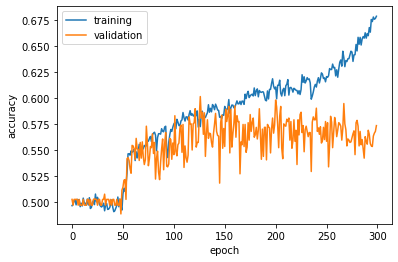

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

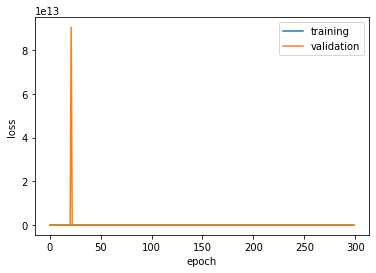

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

In [36]:
model = setupmodel()
json_filename = "TK_core_model.json"

In [37]:
model_json = model.to_json()
with open(json_filename, "w") as json_file : 
    json_file.write(model_json)

In [38]:
from tensorflow.keras.models import model_from_json 
json_file = open(json_filename, "r") 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json)

In [39]:
loaded_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 1e-3),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)
loaded_model.load_weights("checkpoint-TK_core-smalldata.h5")

### Metrics - F1, Recall, Precision

In [40]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from tqdm import tqdm, trange

In [41]:
print("== Evaluate ==")

output_score = []
output_class = []
answer_class = []

for i in trange(len(test_generator)):
    output = loaded_model.predict_on_batch(test_generator[i][0])
    output_score.append(output)
    answer_class.append(test_generator[i][1])
    
output_score = np.concatenate(output_score)
answer_class = np.concatenate(answer_class)

lst = []
for i in output_score:
    val = i[0]
    sublst = [1-val, val]
    lst.append(sublst)
    
output_score = np.array(lst)

print(output_score)
print(answer_class)

output_class = np.argmax(output_score, axis=1)

print(output_class)
print(answer_class)

  0%|          | 0/63 [00:00<?, ?it/s]

== Evaluate ==


100%|██████████| 63/63 [00:41<00:00,  1.52it/s]

[[0.78886884 0.21113116]
 [0.38970435 0.61029565]
 [0.36612535 0.63387465]
 ...
 [0.58410978 0.41589022]
 [0.54418007 0.45581993]
 [0.3950814  0.6049186 ]]
[0. 0. 0. ... 0. 0. 0.]
[0 1 1 ... 0 0 1]
[0. 0. 0. ... 0. 0. 0.]


In [42]:
print(len(answer_class))

cnt = np.sum(answer_class)
print(cnt)

print(len(output_class))
cnt2= np.sum(output_class)
print(cnt2)

2000
1000.0
2000
1477


In [43]:
cm = confusion_matrix(answer_class, output_class)
report = classification_report(answer_class, output_class)

recall = cm[0][0] / (cm[0][0] + cm[0][1])
fallout = cm[1][0] / (cm[1][0] + cm[1][1])

fpr, tpr, thresholds = roc_curve(answer_class, output_score[:, 1], pos_label=1.)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

print(report)
print(cm)
print("AUROC: %f" %(roc_auc_score(answer_class, output_score[:, 1])))
print("THRESH: " , thresh)
print('test_acc: ', len(output_class[np.equal(output_class, answer_class)]) / len(output_class))

              precision    recall  f1-score   support

         0.0       0.66      0.34      0.45      1000
         1.0       0.56      0.82      0.66      1000

    accuracy                           0.58      2000
   macro avg       0.61      0.58      0.56      2000
weighted avg       0.61      0.58      0.56      2000

[[343 657]
 [180 820]]
AUROC: 0.616701
THRESH:  0.5923201441764832
test_acc:  0.5815
